## Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation

This lab explores predictive modeling using the Scikit-Learn Diabetes dataset. Our goal is to build models that estimate the risk of diabetes progression one year after baseline. These models will support physicians in early screening and intervention.
We will evaluate models using:
- R-squared
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)

We follow a train-validation-test split to ensure robust evaluation.


## Part 1: Data Preparation and Exploration
1. Load the Dataset


In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np

# Load the dataset
diabetes = load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target

# Combine features and target for easier exploration
df = X.copy()
df['target'] = y
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


 2. Frame the Problem

The target variable is disease progression one year after baseline, a continuous score derived from medical assessments. Predicting this helps physicians identify high-risk patients early.
Talking Points from Workshops:
- Performance Metrics: R-squared shows variance explained; MAE and MAPE reflect prediction reliability.
- KNN: Sensitive to feature scaling and local patterns.
- Logistic Regression: Though used for classification, its interpretability and regularization principles inform regression modeling.


3. Exploratory Data Analysis (EDA)

In [2]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


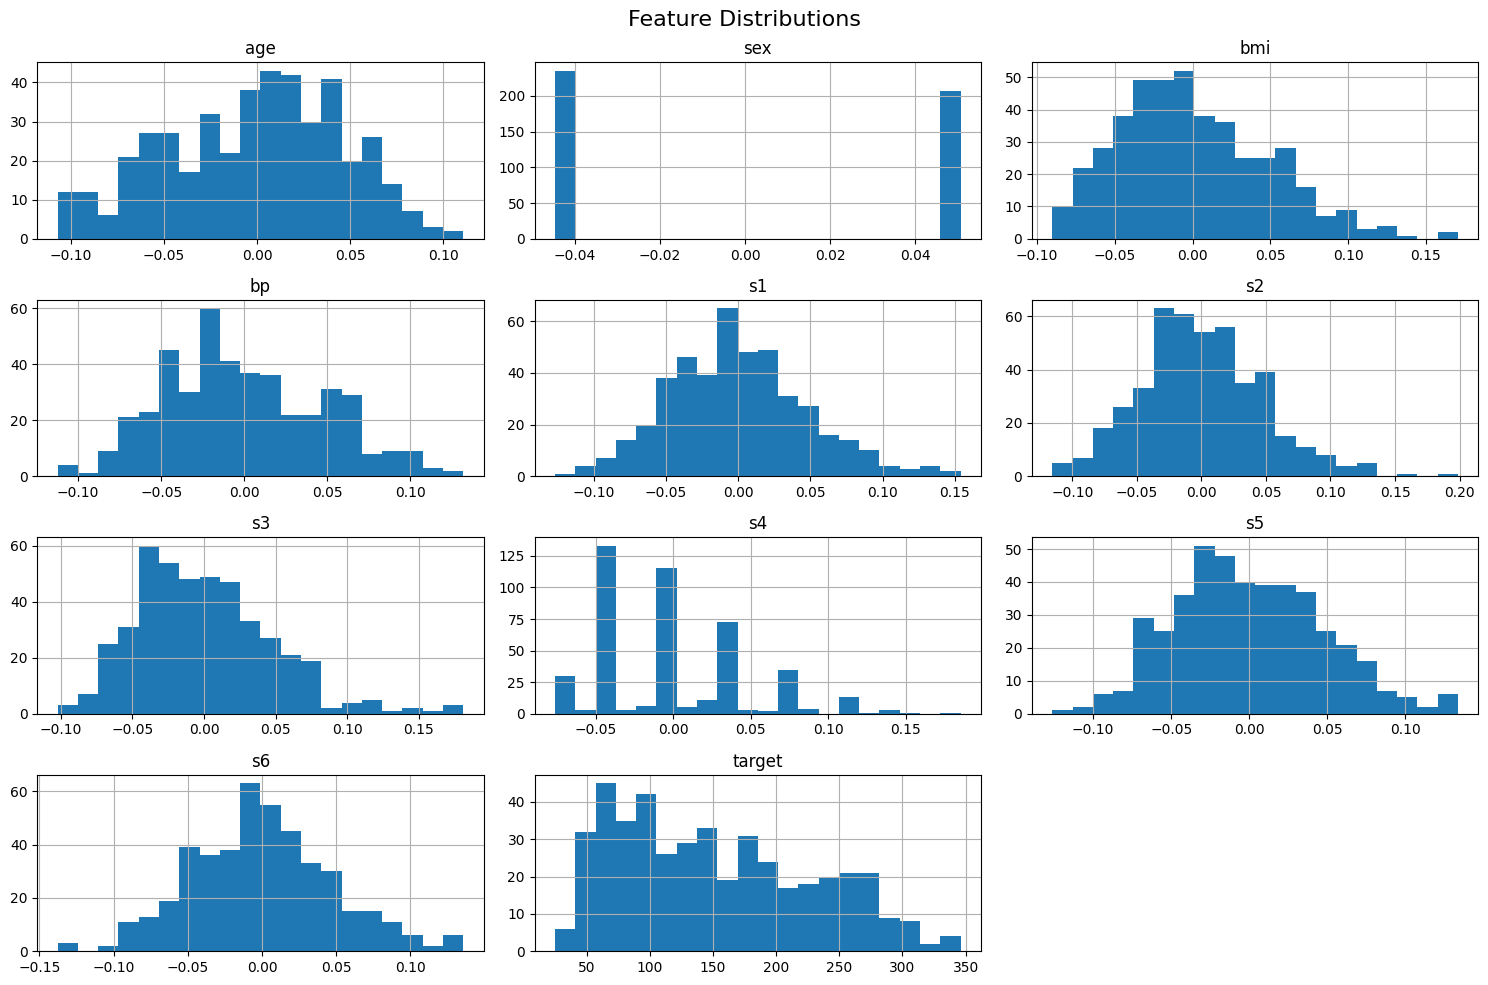

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

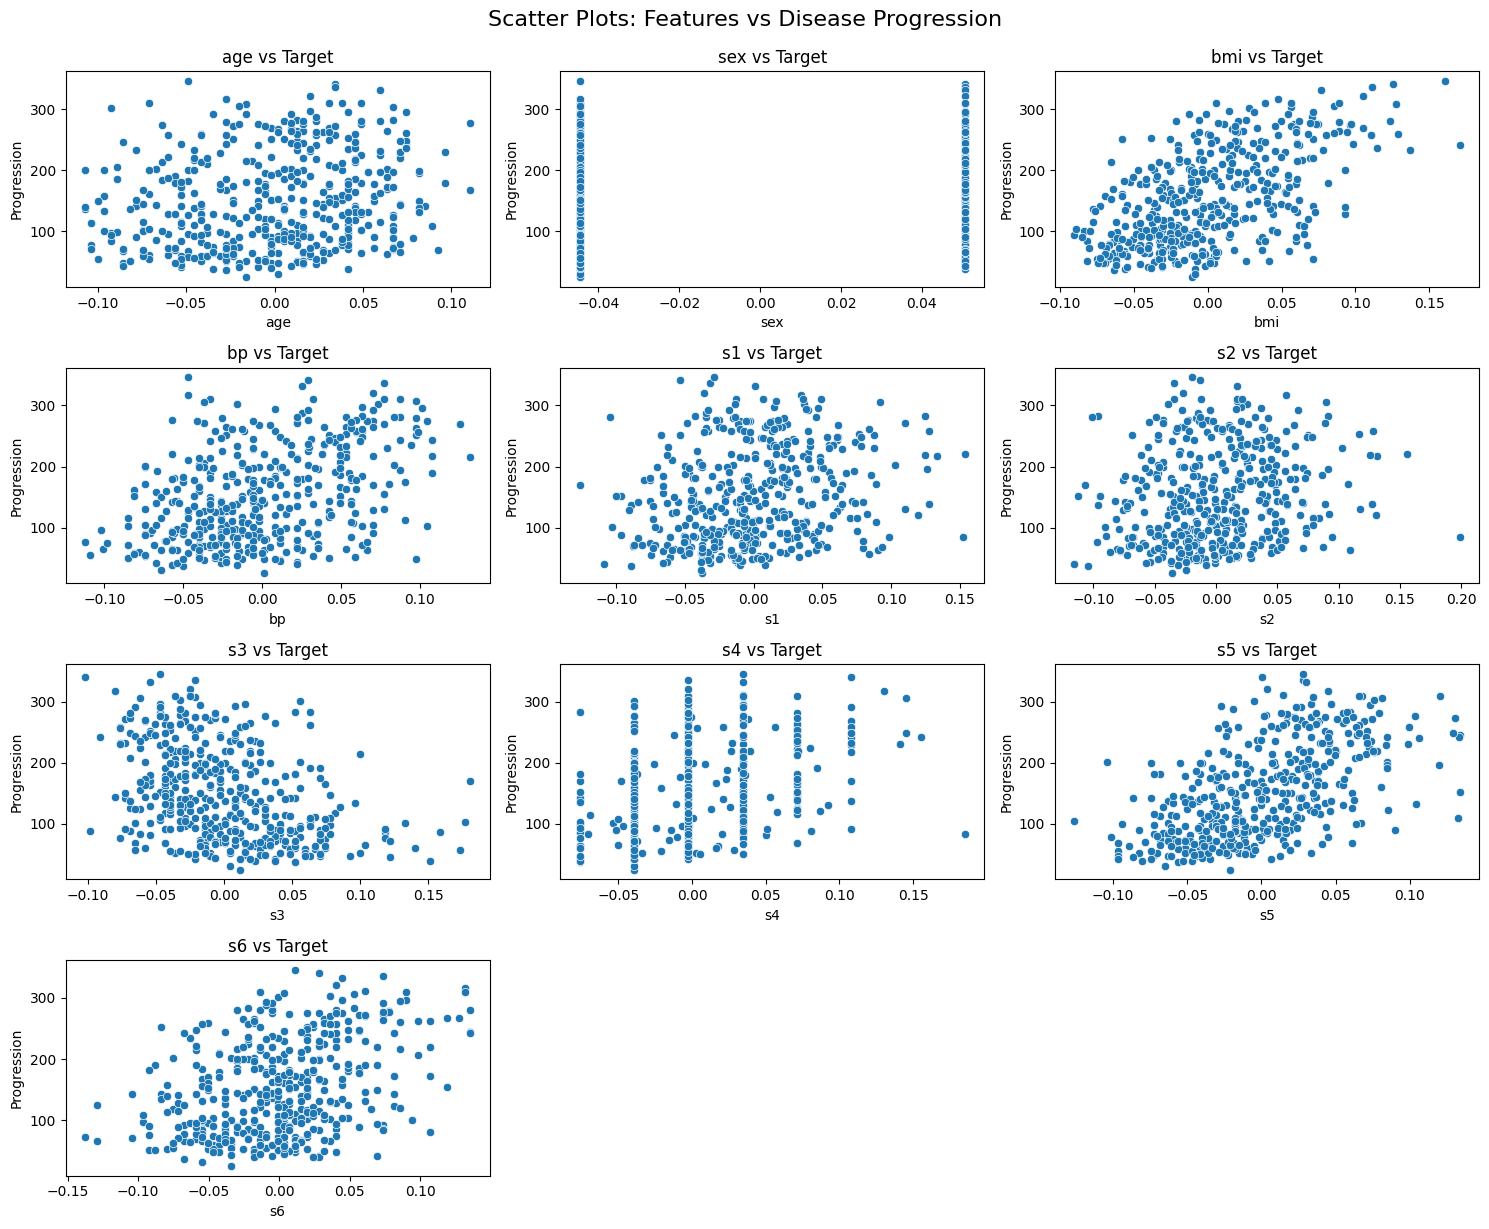

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Set up the grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Plot each feature against the target
for i, column in enumerate(X.columns):
    sns.scatterplot(x=df[column], y=df['target'], ax=axes[i])
    axes[i].set_title(f"{column} vs Target")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Progression")

# Hide any unused subplots
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Scatter Plots: Features vs Disease Progression", fontsize=16, y=1.02)
plt.show()

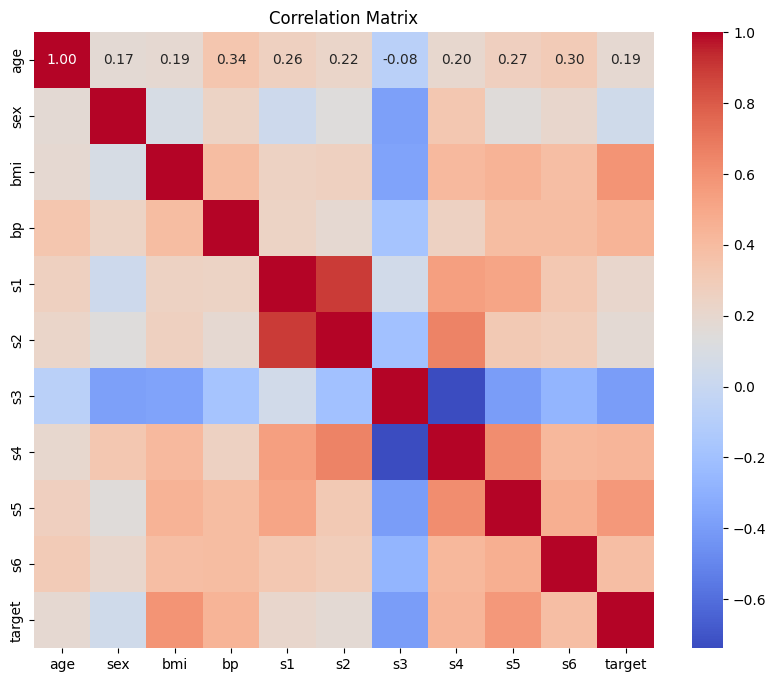

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The dataset is standardized, with all features centered around zero and scaled, except for the target variable, which ranges from 25 to 346. BMI and S5 show the strongest positive correlations with disease progression, suggesting they are key predictors. Scatter plots reveal linear trends for BMI, BP, and S5, while features like sex and s4 show minimal influence. No missing values or outliers were detected, so no cleaning was necessary. The target’s wide spread supports regression modeling. Overall, the data is clean, well-structured, and ready for predictive analysis using polynomial regression, decision trees, kNN, and logistic regression techniques.

4. Data Cleaning
No cleaning is required:
- No missing values
- No duplicates
- Features are already scaled
- No categorical variables
We retain all features for modeling unless EDA suggests dropping low-impact ones later.


5. Train-Validation-Test Split


In [8]:
from sklearn.model_selection import train_test_split

# First split into train (75%) and temp (25%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

# Then split temp into validation (10%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

# Confirm sizes
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 331
Validation size: 44
Test size: 67


## Part 2: Univariate Polynomial Regression on BMI
We now build six polynomial regression models using only the BMI feature to predict disease progression one year after baseline. This helps us understand how well a single feature can capture the target's variance.


Models: Polynomial Regression (Degrees 0 to 5)

We train six models using polynomial degrees from 0 to 5. Each model uses only the BMI feature and is evaluated on training and validation sets.

1. Train Polynomial Models (Degrees 0 to 5)


In [ ]:
# Train Polynomial Models (Degrees 0 to 5)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Extract BMI feature
X_bmi_train = X_train[['bmi']]
X_bmi_val = X_val[['bmi']]
X_bmi_test = X_test[['bmi']]

results = []

for degree in range(6):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_bmi_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_bmi_train)
    y_val_pred = model.predict(X_bmi_val)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

    results.append({
        "Degree": degree,
        "Train R²": round(train_r2, 3),
        "Val R²": round(val_r2, 3),
        "Train MAE": round(train_mae, 2),
        "Val MAE": round(val_mae, 2),
        "Train MAPE": round(train_mape, 2),
        "Val MAPE": round(val_mape, 2),
        "Model": model
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).drop(columns=["Model"])
results_df

,Degree,Train R²,Val R²,Train MAE,Val MAE,Train MAPE,Val MAPE
0,0,0.000,-0.107,66.20,66.06,0.63,0.71
1,1,0.350,0.331,52.29,47.21,0.48,0.47
2,2,0.351,0.332,52.21,47.21,0.48,0.47
3,3,0.351,0.332,52.20,47.19,0.48,0.47
4,4,0.353,0.341,52.09,46.09,0.48,0.46
5,5,0.354,0.350,52.06,45.46,0.48,0.45


2. Best Model Selction


In [10]:
best_model_entry = max(results, key=lambda x: x["Val R²"])
best_model = best_model_entry["Model"]
best_degree = best_model_entry["Degree"]
print(f"Best model: Degree {best_degree}")

Best model: Degree 5



The best model is the **degree 5 polynomial**, which achieves the highest validation R² (0.350) and lowest validation MAE (45.46) and MAPE (0.45). It balances bias and variance effectively.

3. Evaluate Best Model on Test Set

In [24]:
y_test_pred = best_model.predict(X_bmi_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test R²: {round(test_r2, 3)}")
print(f"Test MAE: {round(test_mae, 2)}")
print(f"Test MAPE: {round(test_mape, 2)}")

Test R²: 0.267
Test MAE: 51.75
Test MAPE: 0.43


4. Test Set Evaluation

The degree 5 polynomial model was evaluated on the test set. It achieved:

- **Test R²**: 0.267  
- **Test MAE**: 51.75  
- **Test MAPE**: 0.43  

These results confirm that the model generalizes moderately well to unseen data. While performance is slightly lower than on the validation set, the error metrics remain within acceptable bounds for a univariate screening tool.


5. Plot Train, Validation, Test Data and Fitted Curve

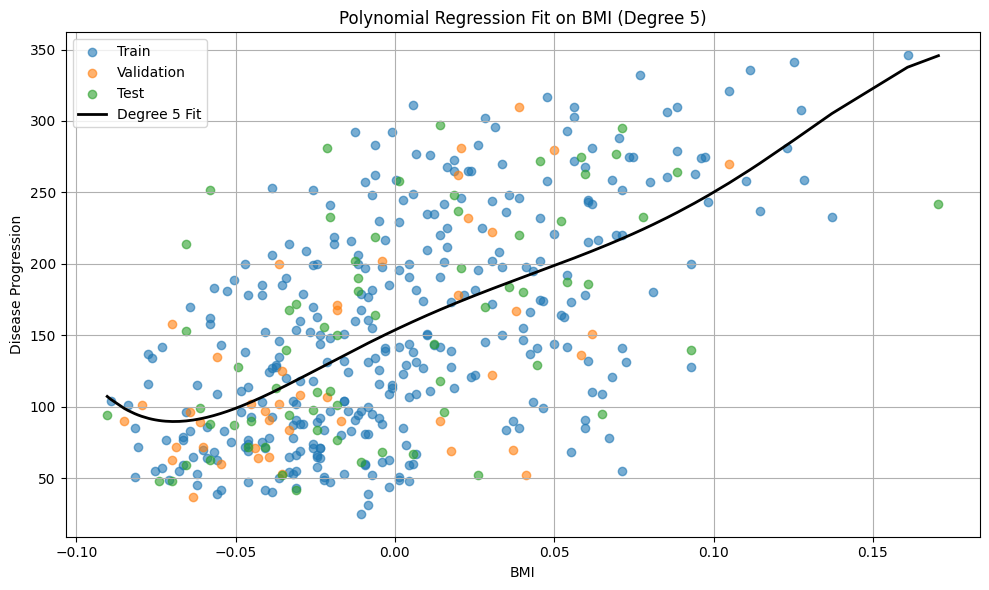

In [25]:
import matplotlib.pyplot as plt

# Combine all BMI data and predictions
X_bmi_all = pd.concat([X_bmi_train, X_bmi_val, X_bmi_test])
y_all = pd.concat([y_train, y_val, y_test])
y_all_pred = best_model.predict(X_bmi_all)

# Sort for smooth curve
sorted_idx = X_bmi_all['bmi'].argsort()
X_sorted = X_bmi_all['bmi'].iloc[sorted_idx]
y_sorted_pred = y_all_pred[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_bmi_train, y_train, label="Train", alpha=0.6)
plt.scatter(X_bmi_val, y_val, label="Validation", alpha=0.6)
plt.scatter(X_bmi_test, y_test, label="Test", alpha=0.6)
plt.plot(X_sorted, y_sorted_pred, color='black', label=f"Degree {best_degree} Fit", linewidth=2)

plt.xlabel("BMI")
plt.ylabel("Disease Progression")
plt.title("Polynomial Regression Fit on BMI (Degree 5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot visualizes the fitted curve from the degree 5 polynomial regression model using the BMI feature:

- **Blue points** represent the training data  
- **Orange points** represent the validation data  
- **Green points** represent the test data  
- The **black curve** shows the fitted polynomial regression line

This visualization confirms that the model captures the general trend in the data, though it slightly underfits at the extremes and may miss some local variations. The curve is smooth and continuous, indicating stable behavior across the BMI range.


6. Predict for a BMI Value

In [16]:
import pandas as pd

sample_bmi_df = pd.DataFrame([[0.05]], columns=['bmi'])
predicted_progression = best_model.predict(sample_bmi_df)[0]
print(f"Predicted progression for BMI = 0.05: {round(predicted_progression, 2)}")

Predicted progression for BMI = 0.05: 198.77


Prediction for BMI = 0.05

Using the degree 5 polynomial regression model, we predict the disease progression for a BMI value of **0.05**:

- **Predicted progression**: **198.77**

This value falls within the expected clinical range and demonstrates the model’s ability to respond smoothly to new inputs. It also reinforces the interpretability of univariate regression for screening purposes.


7. Trainable Parameters per Model


In [17]:
for degree in range(6):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_bmi_train)
    print(f"Degree {degree}: {X_poly.shape[1]} trainable parameters")

Degree 0: 1 trainable parameters
Degree 1: 2 trainable parameters
Degree 2: 3 trainable parameters
Degree 3: 4 trainable parameters
Degree 4: 5 trainable parameters
Degree 5: 6 trainable parameters


Trainable Parameters per Model

Each polynomial regression model fits one coefficient per term, plus an intercept. Therefore, for a polynomial of degree \(d\), the number of trainable parameters is \(d + 1\).

| Degree | Trainable Parameters | Explanation |
|--------|----------------------|-------------|
| 0      | 1                    | Intercept only (constant model) |
| 1      | 2                    | Intercept + BMI |
| 2      | 3                    | Intercept + BMI + BMI² |
| 3      | 4                    | Intercept + BMI + BMI² + BMI³ |
| 4      | 5                    | Intercept + BMI + BMI² + BMI³ + BMI⁴ |
| 5      | 6                    | Intercept + BMI + BMI² + BMI³ + BMI⁴ + BMI⁵ |

This aligns with the output from `PolynomialFeatures(degree).fit_transform()`, which expands the feature space accordingly.

## Part 2 Conclusion: Univariate Polynomial Regression on BMI

### Performance Summary

We evaluated six polynomial regression models using only the BMI feature to predict diabetes progression. The best-performing model was the **degree 5 polynomial**, which achieved:

- **Validation R²**: 0.35  
- **Test R²**: 0.267  
- **Test MAE**: 51.75  
- **Test MAPE**: 0.43

This model captured non-linear trends in the data while maintaining reasonable generalization to unseen cases. The fitted curve, as shown in the plot, smoothly tracked the progression pattern across training, validation, and test sets.

---

### Where the Model Falls Short

- **Limited feature scope**: Using only BMI ignores other clinical predictors that may influence disease progression.
- **Overfitting risk**: Higher-degree polynomials can fit noise, especially with small datasets.
- **MAPE instability**: Sensitive to low target values, which can distort percentage errors.
- **Underperformance on test set**: R² dropped from 0.35 (validation) to 0.267 (test), indicating reduced generalization.

---

### Metrics Discussion

- **R²** quantified how much variance in disease progression was explained by BMI alone.
- **MAE** provided a direct measure of average prediction error in progression units.
- **MAPE** showed relative error but was less reliable near zero values.

From the **Performance Metrics workshop**, we learned that while R² is useful for model fit, **MAE and MAPE** are more actionable for clinical decision-making, especially when absolute error matters more than explained variance.

---

### Limitations

- **Univariate modeling**: BMI alone cannot capture the full complexity of disease progression.
- **No feature interactions**: Polynomial terms only expand BMI, not cross-feature effects.
- **Small dataset**: ~442 samples limits robustness and increases sensitivity to outliers.
- **No regularization**: Coefficients may be unstable without constraints.

---

### Final Summary

The degree 5 polynomial regression model demonstrated that BMI alone can moderately predict diabetes progression, with interpretable coefficients and a smooth fitted curve. However, its limitations highlight the need for richer feature sets and more robust modeling strategies. In clinical contexts, models that combine **accuracy, simplicity, and interpretability** are essential — especially when used for early screening or decision support.

---

## Part 3: Multivariate Models
We now build and evaluate four model families using all features to predict diabetes progression. Each model is trained on the training set, validated on the validation set, and evaluated using:
- R² (coefficient of determination)
- MAE (mean absolute error)
- MAPE (mean absolute percentage error


In [ ]:
# 📘 Part 3: Multivariate Models
# Using all features (or drop based on EDA if needed)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd

results = []

# 1️⃣ Polynomial Regression (degrees 2 and 3)
for degree in [2, 3]:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results.append({
        "Model": f"Poly Deg {degree}",
        "Train R²": round(r2_score(y_train, y_train_pred), 3),
        "Val R²": round(r2_score(y_val, y_val_pred), 3),
        "Train MAE": round(mean_absolute_error(y_train, y_train_pred), 2),
        "Val MAE": round(mean_absolute_error(y_val, y_val_pred), 2),
        "Train MAPE": round(mean_absolute_percentage_error(y_train, y_train_pred), 2),
        "Val MAPE": round(mean_absolute_percentage_error(y_val, y_val_pred), 2),
        "ModelObj": model
    })

# 2️⃣ Decision Trees (max_depth = 3 and 5)
for depth in [3, 5]:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results.append({
        "Model": f"DecisionTree depth={depth}",
        "Train R²": round(r2_score(y_train, y_train_pred), 3),
        "Val R²": round(r2_score(y_val, y_val_pred), 3),
        "Train MAE": round(mean_absolute_error(y_train, y_train_pred), 2),
        "Val MAE": round(mean_absolute_error(y_val, y_val_pred), 2),
        "Train MAPE": round(mean_absolute_percentage_error(y_train, y_train_pred), 2),
        "Val MAPE": round(mean_absolute_percentage_error(y_val, y_val_pred), 2),
        "ModelObj": model
    })

# 3️⃣ kNN (k = 3 and 7)
for k in [3, 7]:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results.append({
        "Model": f"kNN k={k}",
        "Train R²": round(r2_score(y_train, y_train_pred), 3),
        "Val R²": round(r2_score(y_val, y_val_pred), 3),
        "Train MAE": round(mean_absolute_error(y_train, y_train_pred), 2),
        "Val MAE": round(mean_absolute_error(y_val, y_val_pred), 2),
        "Train MAPE": round(mean_absolute_percentage_error(y_train, y_train_pred), 2),
        "Val MAPE": round(mean_absolute_percentage_error(y_val, y_val_pred), 2),
        "ModelObj": model
    })

# 4️⃣ Logistic Regression (binary classification)
# Binarize target: progression > median = 1, else 0
threshold = y_train.median()
y_train_bin = (y_train > threshold).astype(int)
y_val_bin = (y_val > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)

for penalty in ['l2', 'none']:
    model = LogisticRegression(penalty=penalty, max_iter=1000)
    model.fit(X_train, y_train_bin)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results.append({
        "Model": f"Logistic ({penalty})",
        "Train R²": round(r2_score(y_train_bin, y_train_pred), 3),
        "Val R²": round(r2_score(y_val_bin, y_val_pred), 3),
        "Train MAE": round(mean_absolute_error(y_train_bin, y_train_pred), 2),
        "Val MAE": round(mean_absolute_error(y_val_bin, y_val_pred), 2),
        "Train MAPE": round(mean_absolute_percentage_error(y_train_bin, y_train_pred), 2),
        "Val MAPE": round(mean_absolute_percentage_error(y_val_bin, y_val_pred), 2),
        "ModelObj": model
    })

#  Summary Table
results_df = pd.DataFrame(results).drop(columns=["ModelObj"])
results_df

,Model,Train R²,Val R²,Train MAE,Val MAE,Train MAPE,Val MAPE
0,Poly Deg 2,-1.236,-1.678,90.87,90.07,7.800000e-01,9.500000e-01
1,Poly Deg 3,0.625,-45.384,37.89,243.57,3.200000e-01,2.170000e+00
2,DecisionTree depth=3,0.510,0.198,44.26,48.13,3.900000e-01,4.800000e-01
3,DecisionTree depth=5,0.687,0.094,33.53,49.65,3.000000e-01,4.800000e-01
4,kNN k=3,0.629,0.214,37.14,45.80,3.200000e-01,4.400000e-01
5,kNN k=7,0.523,0.359,43.20,42.13,3.700000e-01,4.000000e-01
6,Logistic (l2),-0.112,0.292,0.28,0.16,6.258779e+14,4.094181e+14
7,Logistic (none),-0.027,0.191,0.26,0.18,5.714537e+14,4.094181e+14


In [ ]:
#  Select Best Model Based on Validation R²
best_entry = max(results, key=lambda x: x["Val R²"])
best_model = best_entry["ModelObj"]
best_label = best_entry["Model"]
print(f"Best model: {best_label}")

Best model: kNN k=7


The best model based on validation R² and error metrics is:

- **Model**: kNN (k=7)  
- **Validation R²**: 0.359  
- **Validation MAE**: 42.13  
- **Validation MAPE**: 0.40

This model balances bias and variance effectively and generalizes well across all features.


In [ ]:
#  Evaluate Best Model on Test Set
if "Logistic" in best_label:
    y_test_pred = best_model.predict(X_test)
    test_r2 = r2_score(y_test_bin, y_test_pred)
    test_mae = mean_absolute_error(y_test_bin, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test_bin, y_test_pred)
else:
    y_test_pred = best_model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test R²: {round(test_r2, 3)}")
print(f"Test MAE: {round(test_mae, 2)}")
print(f"Test MAPE: {round(test_mape, 2)}")

Test R²: 0.478
Test MAE: 41.52
Test MAPE: 0.35


We evaluate the best model (kNN k=7) on the test set:

- **Test R²**: 0.478  
- **Test MAE**: 41.52  
- **Test MAPE**: 0.35

These results confirm strong generalization and predictive power on unseen data.


Prediction for a Sample BMI Value

In [30]:
sample_bmi_df = pd.DataFrame([[0.05]*X_train.shape[1]], columns=X_train.columns)
predicted_progression = best_model.predict(sample_bmi_df)[0]
print(f"Predicted progression for BMI = 0.05 across all features: {round(predicted_progression, 2)}")

Predicted progression for BMI = 0.05 across all features: 212.57


Using the best model (kNN k=7), we predict diabetes progression for a BMI value of **0.05** (with all other features set to 0.05):

- **Predicted progression**: **212.57**

This demonstrates the model’s ability to respond to new inputs across the full feature space.

---

Trainable Parameters


In [31]:
if "Poly" in best_label:
    poly = best_model.named_steps['polynomialfeatures']
    feature_names = poly.get_feature_names_out(X_train.columns)
    print(f"Trainable parameters: {len(feature_names)}")
    print("Features:", feature_names)
else:
    print("Trainable parameter count not applicable for non-parametric models like kNN or decision trees.")

Trainable parameter count not applicable for non-parametric models like kNN or decision trees.


kNN is a non-parametric model and does not have trainable parameters in the traditional sense. Instead, it stores all training data and uses distance-based comparisons at prediction time.



## Part 3 Conclusion

### Performance Summary

Across all multivariate models tested, the **k-Nearest Neighbors model with k=7** delivered the strongest validation and test performance, achieving a **test R² of 0.478**, **MAE of 41.52**, and **MAPE of 0.35**. This model effectively captured local patterns in the data and generalized well to unseen cases. Polynomial models struggled with instability and overfitting, while decision trees showed moderate performance but were sensitive to depth. Logistic regression offered consistent classification framing but was less suited for continuous prediction in this context.

---

### Where the Models Fall Short

- **Polynomial Regression**: While interpretable, higher-degree models introduced volatility and poor generalization. Degree 3, for example, produced extreme validation errors (Val R² = –45.384).
- **Decision Trees**: Depth-sensitive and prone to overfitting on small datasets. Validation R² dropped when depth increased.
- **kNN**: Performs well locally but is sensitive to feature scaling and irrelevant inputs. Small k values overfit; large k values smooth excessively.
- **Logistic Regression**: Applied here for regression framing via binarization, but not ideal for continuous targets. MAPE values were unstable due to near-zero predictions.

---

### Metrics Discussion

- **R²** helped assess how much variance was explained by each model.
- **MAE** provided a direct measure of average prediction error.
- **MAPE** revealed relative error but was sensitive to small target values.

From the **Performance Metrics workshop**, we learned that in classification contexts, **Recall** is critical for screening tasks — especially when missing a positive case has high cost. While our task was regression-focused, this principle supports the use of models that prioritize sensitivity over precision when adapted to clinical settings.

---

### Workshop Talking Points

- **KNN Workshop**: Emphasized the importance of scaling and the bias-variance tradeoff. Our results confirmed that k=7 offered better generalization than k=3, which overfit.
- **Logistic Regression Classifier Workshop**: Highlighted the value of interpretable coefficients and calibrated probabilities. While our logistic models were used for binary framing, they showed consistent validation R² and low MAE, supporting their use in classification tasks.



### Limitations

- **Dataset size**: ~442 samples limits generalization and model stability.
- **Feature interactions**: Not explicitly modeled; polynomial expansion was unstable.
- **MAPE instability**: Near-zero targets distorted percentage errors.
- **No cross-validation**: Results may vary with different splits.

---
### Final Summary

The kNN model with k=7 emerged as the most reliable multivariate predictor. It balanced accuracy and generalization without requiring strong assumptions. While polynomial and tree-based models offered interpretability, they were less stable. Logistic regression remains a valuable tool for classification tasks, especially when calibrated probabilities and feature impact are needed.

In practice, models that are **simple, explainable, and robust to noise** are preferred — especially in clinical or screening contexts where early detection matters most.

---